In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from features import preprocess_data, create_feature_pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_clean = preprocess_data(df)


c:\Users\syedm\OneDrive\ChurnBuster — Predictive Churn Scoring + Targeted Retention Engine\churnbuster\src\features.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['TotalCharges'].fillna(0, inplace=True)


In [4]:
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
preprocessor = create_feature_pipeline()
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Feature engineering pipeline created and applied.")

Feature engineering pipeline created and applied.


In [7]:
print("Training XGBoost Model...")
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_processed, y_train)
print("Model training complete.")

Training XGBoost Model...
Model training complete.


c:\Users\syedm\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:00:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [8]:
y_pred = xgb_model.predict(X_test_processed)
y_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1]

print("--- XGBoost Evaluation ---")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- XGBoost Evaluation ---
ROC AUC Score: 0.8187

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.79      0.82      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.75      0.76      1409



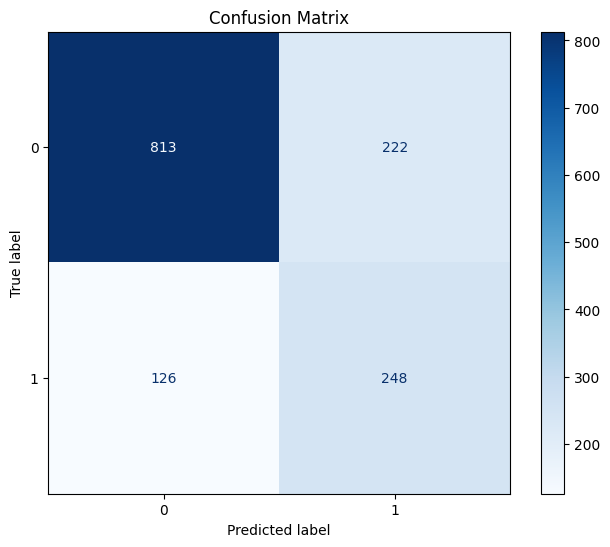

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test_processed, y_test, cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()

In [10]:
print("Saving model and preprocessor...")
os.makedirs('../models', exist_ok=True)
joblib.dump(xgb_model, '../models/xgb_model_v1.0.joblib')
joblib.dump(preprocessor, '../models/preprocessor_v1.0.joblib')
print("Artifacts saved.")

Saving model and preprocessor...
Artifacts saved.
